<a href="https://colab.research.google.com/github/JorgeZarama/TFM-final-models/blob/main/Transformers_An%C3%A1lisis_de_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análisis de Sentimiento Conjunto de Datos Sentiment 140

Vamos a ocupar el Sentiment 140
https://www.kaggle.com/datasets/kazanova/sentiment140/code

# Transformers
https://www.kaggle.com/code/vasudevsrivastava/sentiment-analysis-beginner-deep-learning

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5


2500/2500 [==============================] - 24059s 10s/step - loss: 0.4824 - accuracy: 0.7642 - val_loss: 0.4404 - val_accuracy: 0.7905
Epoch 2/5
2500/2500 [==============================] - 27199s 11s/step - loss: 0.4059 - accuracy: 0.8157 - val_loss: 0.4404 - val_accuracy: 0.7905
Epoch 3/5
2500/2500 [==============================] - 27131s 11s/step - loss: 0.4057 - accuracy: 0.8166 - val_loss: 0.4404 - val_accuracy: 0.7905
Epoch 4/5
2500/2500 [==============================] - 27537s 11s/step - loss: 0.4060 - accuracy: 0.8153 - val_loss: 0.4404 - val_accuracy: 0.7905
Epoch 5/5
313/313 [==============================] - 348s 1s/step - loss: 0.4463 - accuracy: 0.7871
Test Accuracy: 0.7871000170707703
313/313 [==============================] - 346s 1s/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4934
           1       0.79      0.79      0.79      5066

    accuracy                           0.79     10000
  

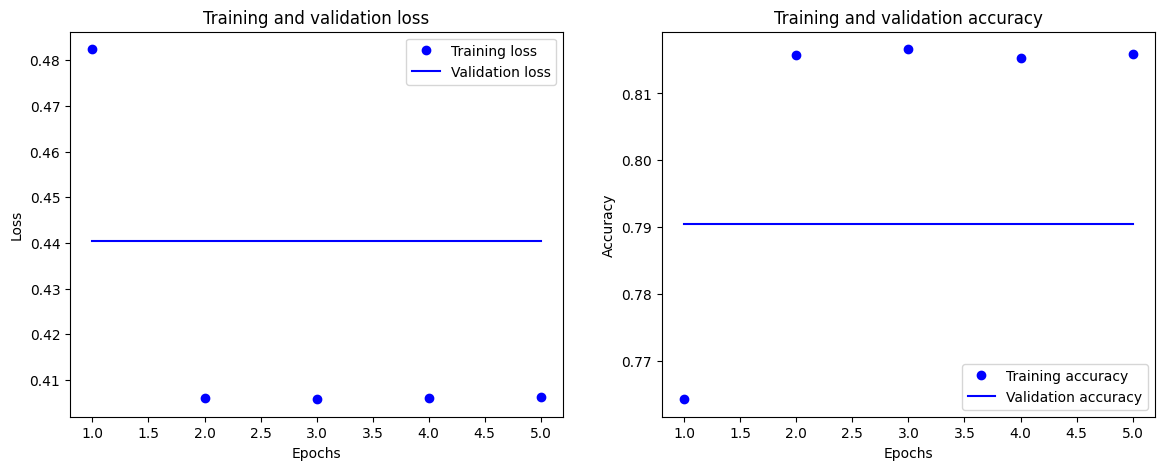

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
import tensorflow as tf

# Cargar datos
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)

# Preprocesar datos
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = url_mention_pattern.sub('', tweet)
    tokens = tweet.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet

df['Preprocessed_text'] = [preprocess_tweet(txt) for txt in df['Text']]
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Tokenización con DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(x_train), truncation=True, padding=True)
val_encodings = tokenizer(list(x_val), truncation=True, padding=True)
test_encodings = tokenizer(list(x_test), truncation=True, padding=True)

# Convertir a formato TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(y_train)
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    list(y_val)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    list(y_test)
))

# Definir el modelo
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Crear optimizador
num_train_steps = len(train_dataset) // 32
num_warmup_steps = num_train_steps // 10
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
)

# Compilar el modelo con la pérdida y las métricas correctas
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Entrenar el modelo sin EarlyStopping
history = model.fit(train_dataset.batch(32), validation_data=val_dataset.batch(32), epochs=5)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(test_dataset.batch(32))
print(f'Test Accuracy: {test_accuracy}')

# Visualizar y evaluar el modelo
def capture_classification_report(model, dataset, y_true):
    predictions = model.predict(dataset.batch(32)).logits
    y_pred = np.argmax(predictions, axis=1)
    report = classification_report(y_true, y_pred)
    return report

classification_report_text = capture_classification_report(model, test_dataset, y_test)
print(classification_report_text)

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    ax1.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
    ax2.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

plot_training_history(history)

# Redes Pre-entrenadas basadas en transformers

## BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
## from transformers
from transformers import BertTokenizer, BertForSequenceClassification, pipeline # Import classes directly from transformers

# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Analizar el sentimiento de una oración
text = "Me encanta este producto, es increíble!"
result = nlp(text)

print(result)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': '5 stars', 'score': 0.909263014793396}]


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Ruta del dataset
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"

# Cargar el dataset
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)


# Función de preprocesamiento del texto
def preprocess_text(text):
    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar preprocesamiento a cada texto
df['Preprocessed_text'] = df['Text'].apply(preprocess_text)

x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [ ]:
print(type(x_test))

<class 'pandas.core.series.Series'>


In [ ]:
# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Analizar el sentimiento de cada tweet y almacenar los resultados
results = []
for text in x_test:
    result = nlp(text)
    results.append(result[0])  # result es una lista con un diccionario
# # Crear una columna para los resultados
Predicted_Sentiment = [result['label'] for result in results]
Confidence_Score = [result['score'] for result in results]

# Crear un DataFrame con las nuevas columnas
new_columns = pd.DataFrame({'Predicted Sentiment': Predicted_Sentiment, 'Confidence Score': Confidence_Score, 'Etiqueta':y_test})

# Concatenar el DataFrame original con las nuevas columnas
all_test = pd.concat([x_test, new_columns], axis=1)
display(all_test)



,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
1015498,people start saying quotyoure older need take ...,3 stars,0.278932,1
1497805,mint icecreammmmm thanks lt,5 stars,0.558860,1
1259172,going comment one isnt selfportrait doesnt sho...,1 star,0.771940,1
381260,people go europe anyway,1 star,0.501590,0
875466,tend lot dayhours shopping moonlight sushi are...,4 stars,0.393417,1
...,...,...,...,...
1223023,workin hard wish glorious sunshine,5 stars,0.504785,1
139868,getting work server upgrades complete fail lim...,3 stars,0.348392,0
574496,work kicking butt need win lottery would help ...,3 stars,0.285566,0
352843,moviesshows credit sad looks like suicide,1 star,0.757739,0


In [ ]:
 #1. Extraer el número de la columna "Predicted Sentiment" y convertirlo a entero
def extract_stars(sentiment):
    if isinstance(sentiment, str):
        return int(sentiment.split()[0])
    return sentiment

all_test['Predicted Sentiment'] = all_test['Predicted Sentiment'].apply(extract_stars)

# 2. Quitar los registros donde "Predicted Sentiment" sea 3
all_test = all_test[all_test['Predicted Sentiment'] != 3]

# 3. Crear la columna "Predicción"
all_test['Predicción'] = all_test['Predicted Sentiment'].apply(lambda x: 1 if x >= 4 else 0)

# Mostrar el DataFrame resultante
display(all_test)



,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta,Predicción
1497805,mint icecreammmmm thanks lt,5,0.558860,1,1
1259172,going comment one isnt selfportrait doesnt sho...,1,0.771940,1,0
381260,people go europe anyway,1,0.501590,0,0
875466,tend lot dayhours shopping moonlight sushi are...,4,0.393417,1,1
134912,wont let emailed amp sundry,1,0.543054,0,0
...,...,...,...,...,...
607369,drama high seas im praying best friends family...,5,0.482060,0,1
892761,moi cest carbo way bon,4,0.411416,1,1
1223023,workin hard wish glorious sunshine,5,0.504785,1,1
352843,moviesshows credit sad looks like suicide,1,0.757739,0,0


Precisión del modelo: 0.69
Matriz de confusión:
[[3077 1284]
 [1434 3041]]
Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.68      0.71      0.69      4361
     Clase 1       0.70      0.68      0.69      4475

    accuracy                           0.69      8836
   macro avg       0.69      0.69      0.69      8836
weighted avg       0.69      0.69      0.69      8836



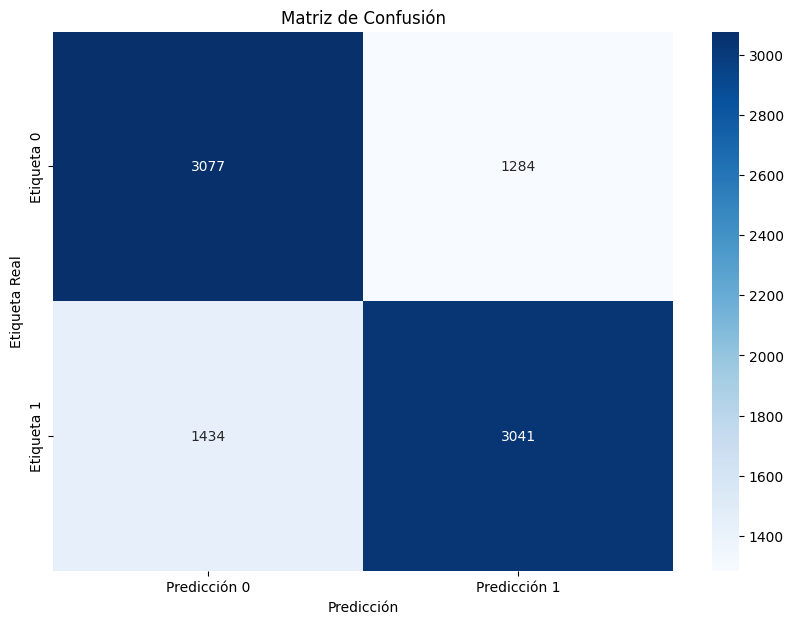

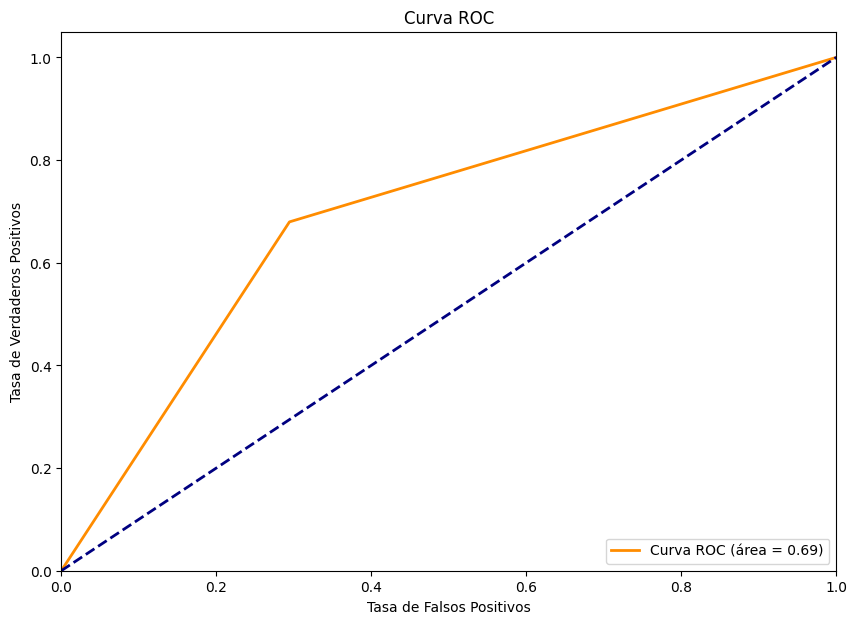

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu DataFrame se llama `all_test`
# Convertir etiquetas y predicciones a listas
y_true = all_test['Etiqueta'].tolist()
y_pred = all_test['Predicción'].tolist()

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'])
print('Reporte de clasificación:')
print(class_report)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Etiqueta 0', 'Etiqueta 1'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
import tensorflow as tf
# Ruta del dataset
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"

# Cargar el dataset
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)

# Preprocesar datos
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")


def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = url_mention_pattern.sub('', tweet)
    tokens = tweet.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet

df['Preprocessed_text'] = [preprocess_tweet(txt) for txt in df['Text']]
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

results = []
for text in x_test:
    result = nlp(text)
    results.append(result[0])  # result es una lista con un diccionario
# # Crear una columna para los resultados
Predicted_Sentiment = [result['label'] for result in results]
Confidence_Score = [result['score'] for result in results]

# Crear un DataFrame con las nuevas columnas
new_columns = pd.DataFrame({'Predicted Sentiment': Predicted_Sentiment, 'Confidence Score': Confidence_Score, 'Etiqueta':y_test})

# Concatenar el DataFrame original con las nuevas columnas
all_test = pd.concat([x_test, new_columns], axis=1)
display(all_test)



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
1015498,people start saying quotyoure older need take ...,3 stars,0.278932,1
1497805,mint icecreammmmm thanks lt3,5 stars,0.584635,1
1259172,going comment one isnt selfportrait doesnt sho...,1 star,0.771940,1
381260,people go europe anyway,1 star,0.501590,0
875466,tend lot dayhours shopping moonlight sushi are...,4 stars,0.393417,1
...,...,...,...,...
1223023,workin hard wish glorious sunshine,5 stars,0.504785,1
139868,getting work server upgrade complete fail limp...,3 stars,0.347605,0
574496,work kicking butt need win lottery would help ...,3 stars,0.285566,0
352843,222 moviesshows credit sad look like suicide,1 star,0.738015,0


In [ ]:
 #1. Extraer el número de la columna "Predicted Sentiment" y convertirlo a entero
def extract_stars(sentiment):
    if isinstance(sentiment, str):
        return int(sentiment.split()[0])
    return sentiment

all_test['Predicted Sentiment'] = all_test['Predicted Sentiment'].apply(extract_stars)

# 2. Quitar los registros donde "Predicted Sentiment" sea 3
all_test = all_test[all_test['Predicted Sentiment'] != 3]

# 3. Crear la columna "Predicción"
all_test['Predicción'] = all_test['Predicted Sentiment'].apply(lambda x: 1 if x >= 4 else 0)

# Mostrar el DataFrame resultante
display(all_test)


,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta,Predicción
1497805,mint icecreammmmm thanks lt3,5,0.584635,1,1
1259172,going comment one isnt selfportrait doesnt sho...,1,0.771940,1,0
381260,people go europe anyway,1,0.501590,0,0
875466,tend lot dayhours shopping moonlight sushi are...,4,0.393417,1,1
134912,wont let emailed amp sundry,1,0.543054,0,0
...,...,...,...,...,...
607369,drama high sea im praying best friend family h...,5,0.457892,0,1
892761,moi cest carbo way bon,4,0.411416,1,1
1223023,workin hard wish glorious sunshine,5,0.504785,1,1
352843,222 moviesshows credit sad look like suicide,1,0.738015,0,0


Precisión del modelo: 0.69
Matriz de confusión:
[[3090 1294]
 [1472 3033]]
Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.68      0.70      0.69      4384
     Clase 1       0.70      0.67      0.69      4505

    accuracy                           0.69      8889
   macro avg       0.69      0.69      0.69      8889
weighted avg       0.69      0.69      0.69      8889



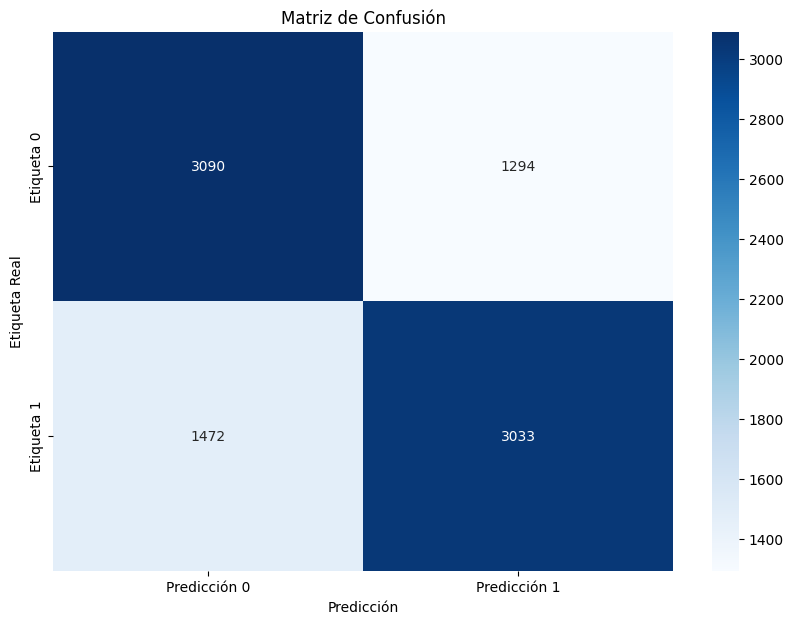

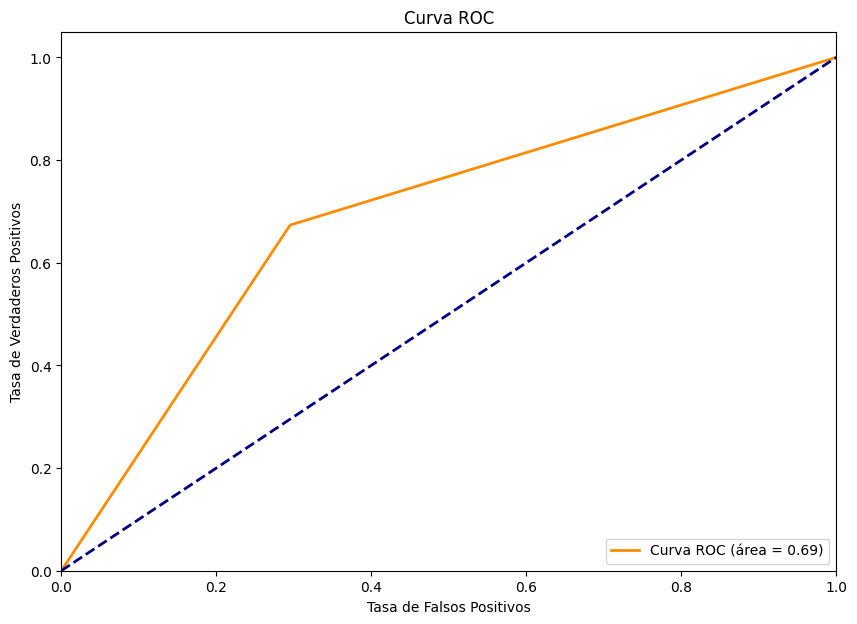

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu DataFrame se llama `all_test`
# Convertir etiquetas y predicciones a listas
y_true = all_test['Etiqueta'].tolist()
y_pred = all_test['Predicción'].tolist()

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'])
print('Reporte de clasificación:')
print(class_report)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Etiqueta 0', 'Etiqueta 1'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## RoBERTa (Robustly optimized BERT approach)

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import pipeline

# Ruta del dataset
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"

# Cargar el dataset
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)

# Preprocesar datos
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")


def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = url_mention_pattern.sub('', tweet)
    tokens = tweet.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet

df['Preprocessed_text'] = [preprocess_tweet(txt) for txt in df['Text']]
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

results = []
for text in x_test:
    result = nlp(text)
    results.append(result[0])  # result es una lista con un diccionario
# # Crear una columna para los resultados
Predicted_Sentiment = [result['label'] for result in results]
Confidence_Score = [result['score'] for result in results]

# Crear un DataFrame con las nuevas columnas
new_columns = pd.DataFrame({'Predicted Sentiment': Predicted_Sentiment, 'Confidence Score': Confidence_Score, 'Etiqueta':y_test})

# Concatenar el DataFrame original con las nuevas columnas
all_test = pd.concat([x_test, new_columns], axis=1)
display(all_test)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jorge\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
1015498,people start saying quotyoure older need take ...,LABEL_1,0.634919,1
1497805,mint icecreammmmm thanks lt3,LABEL_2,0.868940,1
1259172,going comment one isnt selfportrait doesnt sho...,LABEL_1,0.538215,1
381260,people go europe anyway,LABEL_1,0.682209,0
875466,tend lot dayhours shopping moonlight sushi are...,LABEL_1,0.653689,1
...,...,...,...,...
1223023,workin hard wish glorious sunshine,LABEL_2,0.825424,1
139868,getting work server upgrade complete fail limp...,LABEL_1,0.664069,0
574496,work kicking butt need win lottery would help ...,LABEL_2,0.617120,0
352843,222 moviesshows credit sad look like suicide,LABEL_0,0.904122,0


In [ ]:
all_test['Label Number'] = all_test['Predicted Sentiment'].str.extract('(\d+)')
all_test['Label Number'] = all_test['Label Number'].astype(int)
test = all_test.copy()
# # 2. Quitar los registros donde "Predicted Sentiment" sea 3
test = test[test['Label Number'] != 1]
test['Label Number'] = test['Label Number'].replace(2, 1)
# # 3. Crear la columna "Predicción"
# all_test['Predicción'] = all_test['Predicted Sentiment'].apply(lambda x: 1 if x >= 4 else 0)

# Mostrar el DataFrame resultante
display(test)


,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta,Label Number
1497805,mint icecreammmmm thanks lt3,LABEL_2,0.868940,1,1
1200198,much thinking isnt true wayne dyer ex negative...,LABEL_0,0.742624,1,0
41734,whine def need get bigger arsefor dance smh,LABEL_0,0.860660,0,0
1587918,sorry people called weirdo hope make peace,LABEL_0,0.921285,1,0
1219537,love new moon trailer,LABEL_2,0.979196,1,1
...,...,...,...,...,...
607369,drama high sea im praying best friend family h...,LABEL_2,0.884972,0,1
1223023,workin hard wish glorious sunshine,LABEL_2,0.825424,1,1
574496,work kicking butt need win lottery would help ...,LABEL_2,0.617120,0,1
352843,222 moviesshows credit sad look like suicide,LABEL_0,0.904122,0,0


Precisión del modelo: 0.81
Matriz de confusión:
[[2050  662]
 [ 354 2320]]
Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.85      0.76      0.80      2712
     Clase 1       0.78      0.87      0.82      2674

    accuracy                           0.81      5386
   macro avg       0.82      0.81      0.81      5386
weighted avg       0.82      0.81      0.81      5386



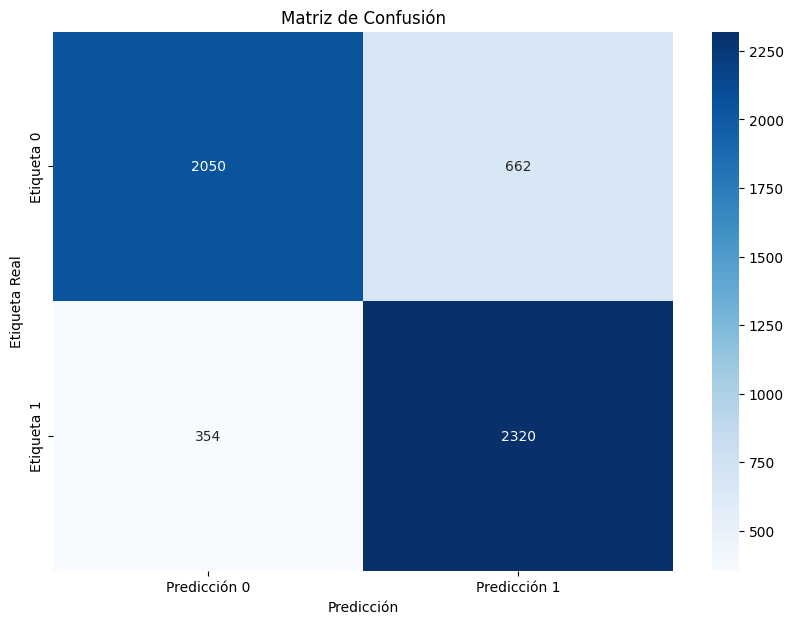

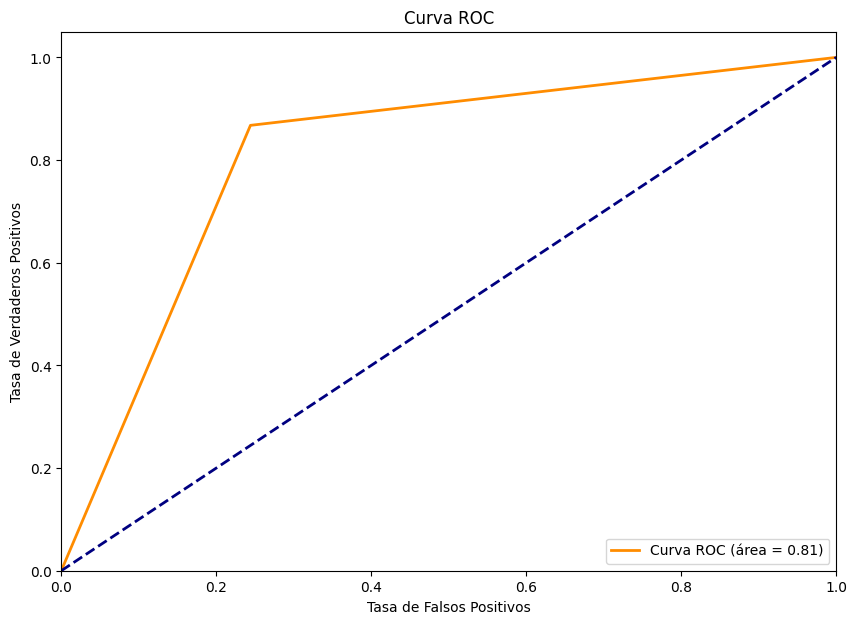

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu DataFrame se llama `all_test`
# Convertir etiquetas y predicciones a listas
y_true = test['Etiqueta'].tolist()
y_pred = test['Label Number'].tolist()

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'])
print('Reporte de clasificación:')
print(class_report)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Etiqueta 0', 'Etiqueta 1'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## DistilBERT

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

# Ruta del dataset
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"

# Cargar el dataset
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)

# Preprocesar datos
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")


def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = url_mention_pattern.sub('', tweet)
    tokens = tweet.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet

df['Preprocessed_text'] = [preprocess_tweet(txt) for txt in df['Text']]
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jorge\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
results = []
for text in x_test:
    result = nlp(text)
    results.append(result[0])  # result es una lista con un diccionario
# # Crear una columna para los resultados
Predicted_Sentiment = [result['label'] for result in results]
Confidence_Score = [result['score'] for result in results]

# Crear un DataFrame con las nuevas columnas
new_columns = pd.DataFrame({'Predicted Sentiment': Predicted_Sentiment, 'Confidence Score': Confidence_Score, 'Etiqueta':y_test})

# Concatenar el DataFrame original con las nuevas columnas
all_test = pd.concat([x_test, new_columns], axis=1)
display(all_test)

,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
1015498,people start saying quotyoure older need take ...,NEGATIVE,0.994270,1
1497805,mint icecreammmmm thanks lt3,POSITIVE,0.970738,1
1259172,going comment one isnt selfportrait doesnt sho...,NEGATIVE,0.984347,1
381260,people go europe anyway,POSITIVE,0.992612,0
875466,tend lot dayhours shopping moonlight sushi are...,POSITIVE,0.998351,1
...,...,...,...,...
1223023,workin hard wish glorious sunshine,POSITIVE,0.999710,1
139868,getting work server upgrade complete fail limp...,NEGATIVE,0.950496,0
574496,work kicking butt need win lottery would help ...,NEGATIVE,0.997543,0
352843,222 moviesshows credit sad look like suicide,NEGATIVE,0.999661,0


In [ ]:
all_test["Predicted Sentiment"].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [ ]:
test = all_test.copy()
test['Predicted Sentiment'] = test['Predicted Sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})
display(test)

,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
1015498,people start saying quotyoure older need take ...,0,0.994270,1
1497805,mint icecreammmmm thanks lt3,1,0.970738,1
1259172,going comment one isnt selfportrait doesnt sho...,0,0.984347,1
381260,people go europe anyway,1,0.992612,0
875466,tend lot dayhours shopping moonlight sushi are...,1,0.998351,1
...,...,...,...,...
1223023,workin hard wish glorious sunshine,1,0.999710,1
139868,getting work server upgrade complete fail limp...,0,0.950496,0
574496,work kicking butt need win lottery would help ...,0,0.997543,0
352843,222 moviesshows credit sad look like suicide,0,0.999661,0


Precisión del modelo: 0.68
Matriz de confusión:
[[3842 1092]
 [2148 2918]]
Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.64      0.78      0.70      4934
     Clase 1       0.73      0.58      0.64      5066

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.69      0.68      0.67     10000



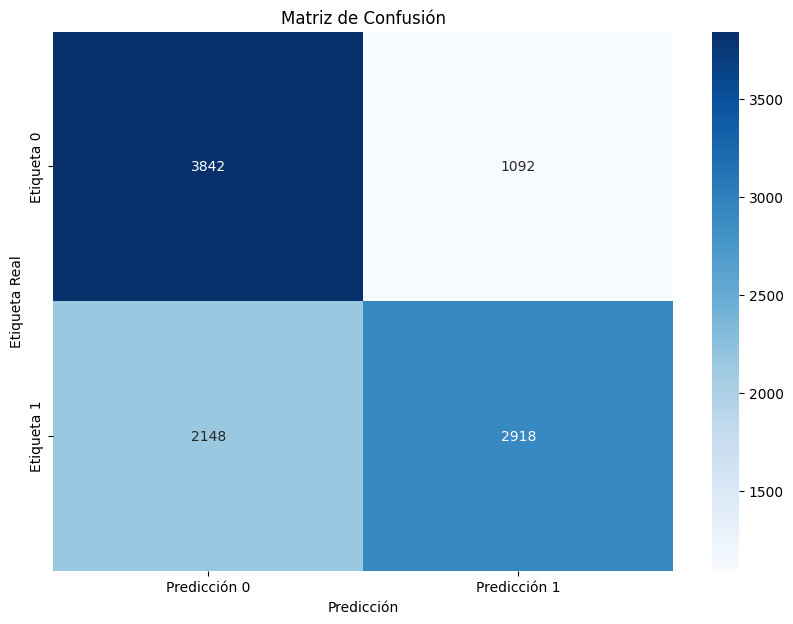

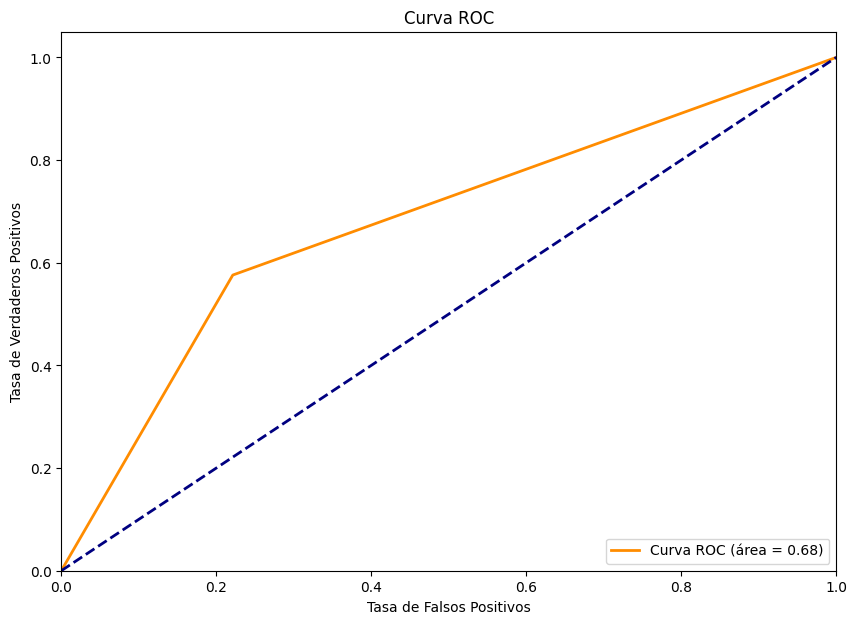

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu DataFrame se llama `all_test`
# Convertir etiquetas y predicciones a listas
y_true = test['Etiqueta'].tolist()
y_pred = test['Predicted Sentiment'].tolist()

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'])
print('Reporte de clasificación:')
print(class_report)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Etiqueta 0', 'Etiqueta 1'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## XLNet

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, create_optimizer
import tensorflow as tf
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import pipeline

# Instala SentencePiece si aún no está instalado
# !pip install sentencepiece

# Ruta del dataset
ruta = "training.1600000.processed.noemoticon.csv"
encoding = "ISO-8859-1"

# Cargar el dataset
df = pd.read_csv(ruta, encoding=encoding, header=None, names=['target','ids','date','flag','user','text'])
df = df.sample(frac=1, random_state=42)[:100000]
df = df[["target", "text"]]
df.rename(columns={"target": 'Sentiment', "text": 'Text'}, inplace=True)
df['Sentiment'] = df['Sentiment'].replace(4, 1)

# Preprocesar datos
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")


def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = url_mention_pattern.sub('', tweet)
    tokens = tweet.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet

df['Preprocessed_text'] = [preprocess_tweet(txt) for txt in df['Text']]
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Cargar el modelo y el tokenizador pre-entrenados
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

# Crear un pipeline para análisis de sentimientos
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
text = "i am very sad"
nlp(text)

[{'label': 'LABEL_1', 'score': 0.568000316619873}]

In [ ]:
results = []
for text in x_test:
    result = nlp(text)
    results.append(result[0])  # result es una lista con un diccionario
# # Crear una columna para los resultados
Predicted_Sentiment = [result['label'] for result in results]
Confidence_Score = [result['score'] for result in results]

# Crear un DataFrame con las nuevas columnas
new_columns = pd.DataFrame({'Predicted Sentiment': Predicted_Sentiment, 'Confidence Score': Confidence_Score, 'Etiqueta':y_test})

# Concatenar el DataFrame original con las nuevas columnas
all_test = pd.concat([x_test, new_columns], axis=1)
display(all_test.sample(30))

,Preprocessed_text,Predicted Sentiment,Confidence Score,Etiqueta
233592,wanted hollie win serpose diversity ok,LABEL_1,0.525186,0
176573,great day apart fact bought usb hub soon plugg...,LABEL_1,0.582860,0
1564113,first cam show tuesday 9pm est,LABEL_1,0.523970,1
917668,still bed enjoying spring sunshine streaming w...,LABEL_1,0.582352,1
442216,aww hoping could jam together,LABEL_1,0.706812,0
1416400,thinking raquel reed stunning,LABEL_0,0.586455,1
830891,sorry late reply went breakfast yeah thats pic...,LABEL_1,0.572115,1
867058,going die anywayseveryone peeing pant somethin...,LABEL_1,0.513490,1
1267216,watching dmb concert fusehulu amazing theyre p...,LABEL_1,0.583854,1
1494433,boyfriend house,LABEL_1,0.684053,1


In [ ]:
all_test["Predicted Sentiment"].unique()

array(['LABEL_0', 'LABEL_1'], dtype=object)

In [ ]:
test = all_test.copy()
test['Predicted Sentiment'] = test['Predicted Sentiment'].map({'LABEL_0': 0, 'LABEL_1': 1})
display(test)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu DataFrame se llama `all_test`
# Convertir etiquetas y predicciones a listas
y_true = test['Etiqueta'].tolist()
y_pred = test['Predicted Sentiment'].tolist()

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1'])
print('Reporte de clasificación:')
print(class_report)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Etiqueta 0', 'Etiqueta 1'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()